In [107]:
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import re
import lxml
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',1000)

## Web Scrapers and Data Cleaning Functions

#### ESPN.COM Salary Web Scraper

In [133]:
def scrape_salary(start_year,end_year):
    player_salary = pd.DataFrame()
    url = 'http://www.espn.com/nba/salaries/_/year/'
    counter = 0
    
    for i in range(start_year+1,end_year+2):
        counter = counter + 1
        espn_req = requests.get(url + str(i))
        espn_text = espn_req.text
        espn_bs = BeautifulSoup(espn_text, 'lxml')
        
        #get the page numbers
        page = espn_bs.find_all(attrs = {'class':'page-numbers'})
        page = int(page[0].getText().split(" ")[2])

        #loop through page numbers and get salaries
        for j in range(1,page+1):
            espn_req = requests.get(url + str(i) + '/page/' + str(j))
            espn_text = espn_req.text
            espn_bs = BeautifulSoup(espn_text, 'lxml')
            
            evens = espn_bs.find_all(attrs = {'class':'evenrow'})
            odds = espn_bs.find_all(attrs = {'class':'oddrow'})
            
            for k in evens:
                dummy = pd.DataFrame()
                dummy["Player"] = [k.find_all('a')[0].getText()]
                dummy["salary"] = [int(k.find_all('td')[3].getText().strip('$').replace(',',''))]
                dummy["year"] = [i-1]
                player_salary = player_salary.append(dummy)
                
            for k in odds:
                dummy = pd.DataFrame()
                dummy["Player"] = [k.find_all('a')[0].getText()]
                dummy["salary"] = [int(k.find_all('td')[3].getText().strip('$').replace(',',''))]
                dummy["year"] = [i-1]
                player_salary = player_salary.append(dummy)
                
        print(str(round((counter/(end_year-start_year+1))*100,2)) + "% Complete")
                
    return(player_salary)
            
    

#### ESPN.COM Web Scraper for PER and EWA

In [138]:
def scrape_PER_EWA(start_year,end_year):
    player_salary = pd.DataFrame()
    url = 'http://insider.espn.com/nba/hollinger/statistics/_/year/'
    counter = 0
    
    for i in range(start_year+1,end_year+2):
        counter = counter + 1
        espn_req = requests.get(url + str(i))
        espn_text = espn_req.text
        espn_bs = BeautifulSoup(espn_text, 'lxml')
        
        #get the page numbers
        page = espn_bs.find_all(attrs = {'class':'page-numbers'})
        page = int(page[0].getText().split(" ")[2])

        #loop through page numbers and get salaries
        for j in range(1,page+1):
            espn_req = requests.get(url + str(i) + '/page/' + str(j))
            espn_text = espn_req.text
            espn_bs = BeautifulSoup(espn_text, 'lxml')
            
            
            
            
            evens = espn_bs.find_all(attrs = {'class':'evenrow'})
            odds = espn_bs.find_all(attrs = {'class':'oddrow'})
            
            for k in evens:
                dummy = pd.DataFrame()
                dummy["Player"] = [k.find_all('a')[0].getText()]
                dummy["PER"] = [float(k.find_all('td')[11].getText())]
                dummy["EWA"] = [float(k.find_all('td')[12].getText())]
                dummy["year"] = [i-1]
                player_salary = player_salary.append(dummy)
                
            for k in odds:
                dummy = pd.DataFrame()
                dummy["Player"] = [k.find_all('a')[0].getText()]
                dummy["PER"] = [float(k.find_all('td')[11].getText())]
                dummy["EWA"] = [float(k.find_all('td')[12].getText())]
                dummy["year"] = [i-1]
                player_salary = player_salary.append(dummy)
                
        print(str(round((counter/(end_year-start_year+1))*100,2)) + "% Complete")
                
    return(player_salary)

#### CSV Cleaner for Basketball-Reference CSV's

In [109]:
def clean_season_csv(csv_df):
    
    new_names = pd.DataFrame()
    
    for index,row in csv_df.iterrows():
        rdf = pd.DataFrame()
        rdf["Player"] = [row["Player"].split('\\')[0]]
        new_names = new_names.append(rdf)
    
    csv_df["Player"] = list(new_names["Player"])
    
    return(csv_df)
    

## Functions for Regression

#### Simple Regression (with plotting assistance)

In [110]:
def simple_regress(X,y):
    X1 = X.values.reshape(-1,1)
    y1 = y.values.reshape(-1,1)
    #Split Data Set
    from sklearn.cross_validation import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size = 1/5)
    
    from sklearn.linear_model import LinearRegression
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    print("R-squared =",regressor.score(X_test,y_test))
    
    plt.figure(figsize=(20,10))
    plt.scatter(X_test, y_test, color = "blue", alpha = .1)
    plt.plot(X_test, regressor.predict(X_test), color = "red")

#### Simple Regression for Small Data Sets (no plotting assistance)

In [111]:
def simple_regress_noplot_small(X,y):
    X1 = X.values.reshape(-1,1)
    y1 = y.values.reshape(-1,1)
    #Split Data Set
    #from sklearn.cross_validation import train_test_split
    #X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size = 1/5)
    
    from sklearn.linear_model import LinearRegression
    regressor = LinearRegression()
    regressor.fit(X1, y1)
    print("R-squared =",regressor.score(X1,y1))
    return(regressor)

In [114]:
# Multivariate Data Analysis Backwards Elimination

#Backwards Elim.
import statsmodels.formula.api as sm
def backwardElimination(x, SL):
    numVars = len(x[0])
    temp = np.zeros((353,23)).astype(int)
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        adjR_before = regressor_OLS.rsquared_adj.astype(float)
        if maxVar > SL:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    temp[:,j] = x[:, j]
                    x = np.delete(x, j, 1)
                    tmp_regressor = sm.OLS(y, x).fit()
                    adjR_after = tmp_regressor.rsquared_adj.astype(float)
                    if (adjR_before >= adjR_after):
                        x_rollback = np.hstack((x, temp[:,[0,j]]))
                        x_rollback = np.delete(x_rollback, j, 1)
                        print(regressor_OLS.summary())
                        return(x_rollback)
                    else:
                        continue
    regressor_OLS.summary()
    return(x)

---

# Analysis of Salaries relationship with NBA statistics
## Questions we wish to answer
#### 1. Which if any statistical Categories are the most correlated with the salary of a player within the NBA?
#### 2. Can we develop a model that can accurately predict a player's Salary based on their performance statistics?
#### 3. According to the above model, which players are the most the most over and under paid?
#### 4. How does our model match up with other aggregrate statistical models? Such as PER and EWA

In [115]:
# Read in stats for each year and combine into dataframe
stats = pd.DataFrame()
for year in range(1999,2018):
    csv_loc = "Stats/" + str(year) + ".csv"
    csv_file = pd.read_csv(csv_loc)
    csv_file = clean_season_csv(csv_file)
    csv_file["year"] = [year]*len(csv_file)
    stats = stats.append(csv_file)

In [116]:
# Scrape the salaries for 1999-2017
Sal_99_17 = scrape_salary(1999,2017)

5.26% Complete
10.53% Complete
15.79% Complete
21.05% Complete
26.32% Complete
31.58% Complete
36.84% Complete
42.11% Complete
47.37% Complete
52.63% Complete
57.89% Complete
63.16% Complete
68.42% Complete
73.68% Complete
78.95% Complete
84.21% Complete
89.47% Complete
94.74% Complete
100.0% Complete


In [117]:
#Salary Cap
salary_cap = pd.read_csv("Stats/Salary by Year.csv")
salary_cap = salary_cap.drop("adj. Salary", axis=1)

#Fix years & adjust for dollars across years
new_year = pd.DataFrame()
for index,row in salary_cap.iterrows():
    ydf = pd.DataFrame()
    ydf["Year"] = [int(row["Year"].split('-')[0])]
    ydf["Salary Cap"] = [int(row["Salary Cap"].strip("$").replace(',',''))]
    new_year = new_year.append(ydf)
salary_cap["year"] = list(new_year["Year"])
salary_cap["Salary Cap"] = list(new_year["Salary Cap"])
salary_cap = salary_cap.drop("Year", axis = 1)

#merge
sal_merge = Sal_99_17.merge(salary_cap, how = "left", on = "year")
sal_merge["adj Sal"] = sal_merge["salary"] / sal_merge["Salary Cap"]

In [118]:
#merge and drop NA's
final = sal_merge.merge(stats, how = "left", on = ["year","Player"])
final = final.dropna()

# Simple Analysis of Salaries

#### Age vs Adjusted Salary

Text(0,0.5,'Adjusted Salary')

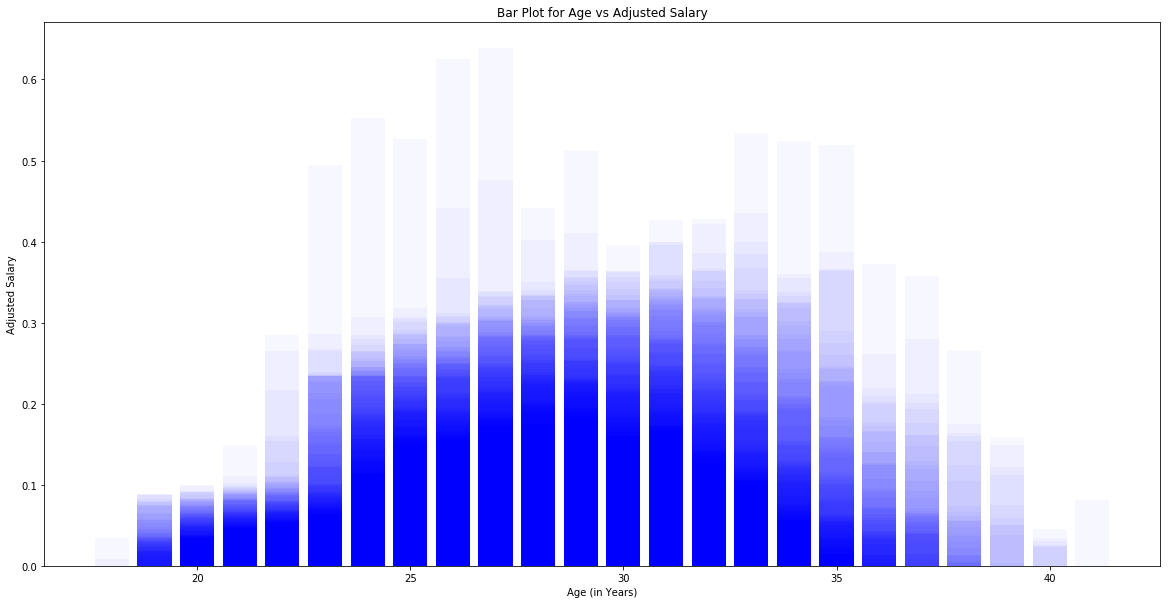

In [119]:
plt.figure(figsize = (20,10))
plt.bar(final["Age"],final["adj Sal"],alpha = .03,color = "blue")
plt.title("Bar Plot for Age vs Adjusted Salary")
plt.xlabel("Age (in Years)")
plt.ylabel("Adjusted Salary")

#### Observation
There is a fairly clear non-linear trend that suggests that player's salary's peak at 29-31 and gruadually decline after.  The jump we see in salary between Ages 22 and 23 is most likely do to players leaving their rookie contracts.  This trend is very expected

### Simple Regression of the Big 3 statistics (Points, Rebounds, & Assists)

#### Points Per Game vs Adjusted Salary

R-squared = 0.34485478656637014


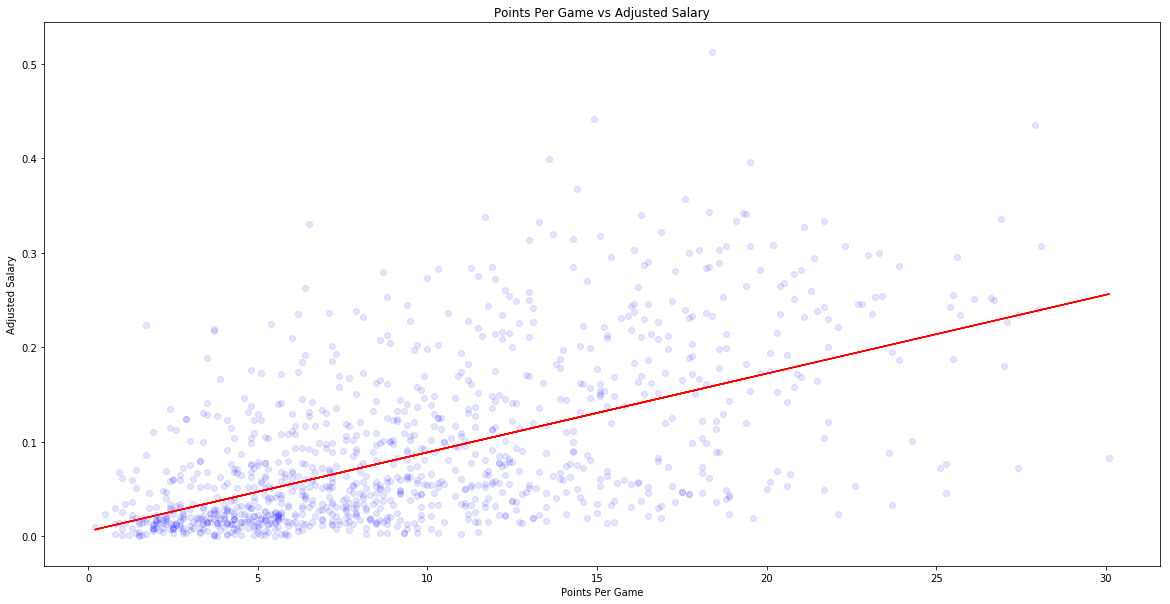

In [120]:
simple_regress(final["PS/G"],final["adj Sal"])
plt.title("Points Per Game vs Adjusted Salary")
plt.xlabel("Points Per Game")
plt.ylabel("Adjusted Salary")
plt.show()

#### Observation
We see a weak positive correlation between Points Per Game and Adjusted Salary 

#### Assists vs Adjusted Salary

R-squared = 0.1405224482996743


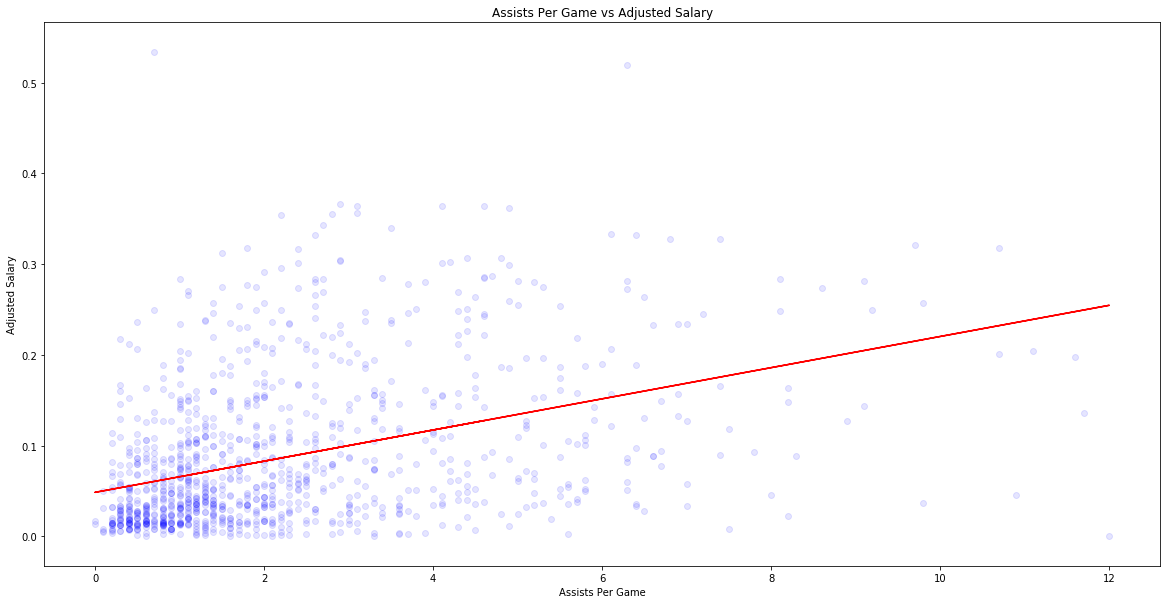

In [121]:
simple_regress(final["AST"],final["adj Sal"])
plt.title("Assists Per Game vs Adjusted Salary")
plt.xlabel("Assists Per Game")
plt.ylabel("Adjusted Salary")
plt.show()

#### Observation
There is a very weak positive correlation between Assists per Game and Adjusted Salary

#### Rebounds per Game vs Adjusted Salary

R-squared = 0.21695359723808227


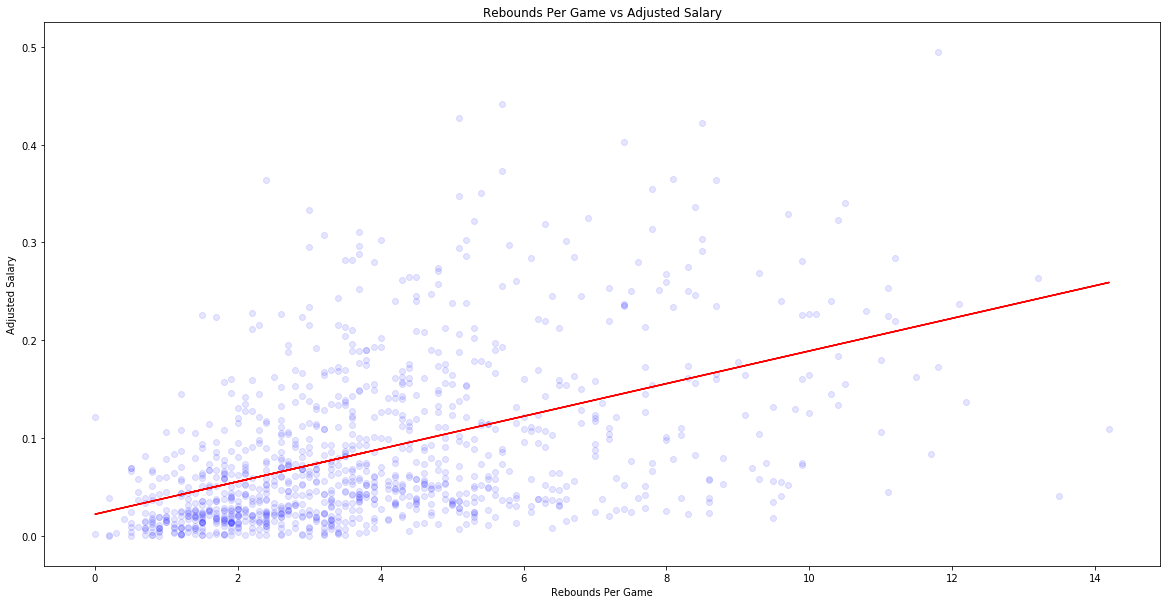

In [122]:
simple_regress(final["TRB"],final["adj Sal"])
plt.title("Rebounds Per Game vs Adjusted Salary")
plt.xlabel("Rebounds Per Game")
plt.ylabel("Adjusted Salary")
plt.show()

#### Observation
There is a weak positive correlation between Rebounds per Game and Adjusted Salary

#### Effective FG% vs Adjusted Salary

R-squared = 0.026794824022227992


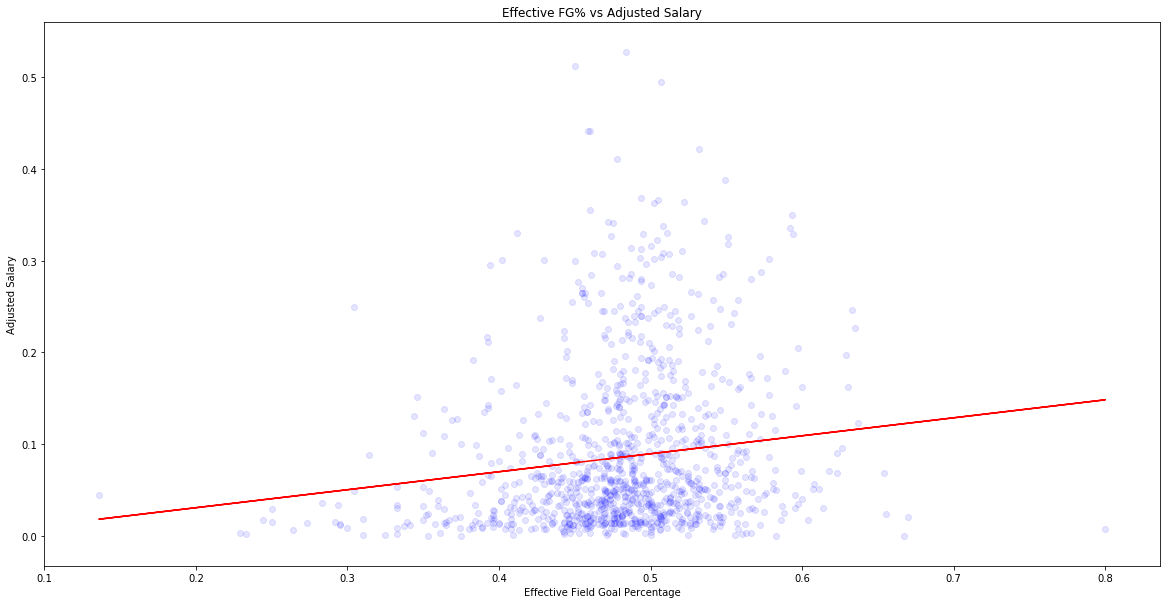

In [131]:
plt.figure(figsize=(20,10))
#plt.scatter(final["eFG%"],final["adj Sal"], alpha = .15)
simple_regress(final["eFG%"],final["adj Sal"])

plt.title("Effective FG% vs Adjusted Salary")
plt.xlabel("Effective Field Goal Percentage")
plt.ylabel("Adjusted Salary")
plt.show()

#### Observations
While touted as an "advanced statistic" by many experts, there seems to be basically zero correlation between Effective FG% and Adjusted Salary

# Multivariate Analysis of Salaries

In [163]:
#Set up for multivariate analysis by removing redundant columns
final.head(1)
mult_final = final.drop(["Tm","salary","Salary Cap","Rk","Pos","G","GS","FG","FGA","3PA","2PA","eFG%","FTA","TRB"], axis = 1)
mult_final.head(1)

,Player,year,adj Sal,Age,MP,FG%,3P,3P%,2P,2P%,FT,FT%,ORB,DRB,AST,STL,BLK,TOV,PF,PS/G
0,Kevin Garnett,1999,0.494294,23.0,40.0,0.497,0.4,0.37,9.0,0.504,3.8,0.765,2.8,9.0,5.0,1.5,1.6,3.3,2.5,22.9


In [165]:
X_pan = mult_final.iloc[:,3:]
X = X_pan.values
y = mult_final["adj Sal"].values


from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state=0)

# fitting simple linear regression to the Training set
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)

from sklearn.feature_selection import RFE
import statsmodels.formula.api as sm

selector = RFE(regressor,11,step=1)
selector = selector.fit(X,y)
cut_col = selector.support_

X_pan = X_pan.iloc[:,cut_col]
X = X_pan.values
regressor_OLS = sm.OLS(y, X).fit()
print(regressor_OLS.summary())
list(regressor_OLS.predict(X[0]))
cut_col[0]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     1533.
Date:                Sun, 18 Mar 2018   Prob (F-statistic):               0.00
Time:                        13:26:52   Log-Likelihood:                 7544.1
No. Observations:                5341   AIC:                        -1.507e+04
Df Residuals:                    5330   BIC:                        -1.499e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0058      0.000     33.842      0.0

True

In [699]:
mult_final.head()

,Player,year,adj Sal,Age,MP,FG%,3P,3P%,2P,2P%,FT,FT%,ORB,DRB,AST,STL,BLK,TOV,PF,PS/G,Sal Difference,Sal Predictions
0,Kevin Garnett,1999,0.494294,23.0,40.0,0.497,0.4,0.370,9.0,0.504,3.8,0.765,2.8,9.0,5.0,1.5,1.6,3.3,2.5,22.9,0.240894,0.240894
1,Juwan Howard,1999,0.441176,26.0,35.5,0.459,0.0,0.000,6.2,0.462,2.5,0.735,1.6,4.1,3.0,0.8,0.3,2.7,3.6,14.9,0.136932,0.136932
4,Shawn Kemp,1999,0.317059,30.0,30.4,0.417,0.0,0.333,5.9,0.418,6.0,0.776,2.8,6.0,1.7,1.2,1.2,3.5,4.5,17.8,0.192090,0.192090
5,Antonio McDyess,1999,0.291176,25.0,33.3,0.507,0.0,0.000,7.6,0.508,4.0,0.626,2.9,5.6,2.0,0.9,1.7,2.8,3.9,19.1,0.190207,0.190207
6,Antoine Walker,1999,0.264706,23.0,36.6,0.430,0.9,0.256,7.0,0.471,3.8,0.699,2.4,5.5,3.7,1.4,0.4,3.2,3.2,20.5,0.176865,0.176865


In [700]:
#find predicted salary for each player

ndf = []
for index,row in X_pan.iterrows():
    prediction = list(regressor_OLS.predict(row.values))
    ndf += prediction
mult_final["Sal Prediction"] = ndf
mult_final["Sal Difference"] = mult_final["adj Sal"] - mult_final["Sal Prediction"]

### Top 10 Overpaid Players Since 1999

In [704]:
top10 = mult_final.sort_values("Sal Difference").tail(10)
bot10 = mult_final.sort_values("Sal Difference").head(10)

In [610]:
def player_year_combiner(df):
    player = []
    for index,row in df.iterrows():
        name = [row["Player"] + " " + str(row["year"])]
        player += name
    df["Player"] = player
    return(df)

In [676]:
#top10 = player_year_combiner(topbot10)

In [702]:
top10 = top10.sort_values("Sal Difference",ascending = False)
top10 = top10.reset_index(drop=True)

In [703]:
top10[["Player","year","Sal Difference"]]

,Player,year,Sal Difference
0,Shawn Kemp,2002,0.416972
1,Kevin Garnett,2002,0.350374
2,Kobe Bryant,2013,0.336792
3,Kevin Garnett,2003,0.336186
4,Juwan Howard,2002,0.326213
5,Kevin Garnett,2000,0.308466
6,Juwan Howard,1999,0.304245
7,Juwan Howard,2000,0.302282
8,Allan Houston,2004,0.287723
9,Kevin Garnett,2001,0.286604


In [716]:
KG = mult_final[mult_final["Player"] == "Kevin Garnett"]
KG[KG["year"] == 1999]["Sal Difference"]

0    0.2534
Name: Sal Difference, dtype: float64

#### Observations and findings
The most overpaid player was Shawn Kemp in the 2002-2003 season, where he was overpaid by 41.7% of the 2002 Salary Cap. It's interesting to note that 2 of the players appear more than once in the top 10.  Those being Kevin Garnett (4 times) and Juwan Howard (3 times).  With Kevin Garnett, I found that he was offered a large contract in 1997, that took effect in the 1999 season.  From our data, we see that his 1999 season salary difference was also very high, at 25.34% of the salary cap.  A similar story can be seen with Juwan Howard from 1999-2002.  Both of these players never lived up to their large contracts.

### Top 10 Most underpaid players since 1999

In [694]:
bot10 = bot10.reset_index(drop=True)
bot10[["Player","year","Sal Difference"]]

,Player,year,Sal Difference
0,Amir Johnson,2005,-0.097499
1,Demetrius Jackson,2016,-0.066011
2,Terrance Ferguson,2017,-0.055758
3,Jarrett Jack,2016,-0.051161
4,Henry Walker,2008,-0.046797
5,D.J. Wilson,2017,-0.045714
6,Scott Machado,2012,-0.045693
7,Jason Hart,2001,-0.041022
8,Jared Cunningham,2012,-0.037004
9,Sergey Karasev,2013,-0.033064


#### Observations and findings
The most underpaid player was Amir Johnson in the 2005-2006 season, where he was underpaid by 9.74% of the salary cap. We can also see that there are no repeats, and underpaid players seem to be one-offs.  

## Evaluation of PER and EWA

#### Read in the data

In [143]:
per_ewa = scrape_PER_EWA(2002,2017)
salaries_2002 = scrape_salary(2002,2017)

6.25% Complete
12.5% Complete
18.75% Complete
25.0% Complete
31.25% Complete
37.5% Complete
43.75% Complete
50.0% Complete
56.25% Complete
62.5% Complete
68.75% Complete
75.0% Complete
81.25% Complete
87.5% Complete
93.75% Complete
100.0% Complete
6.25% Complete
12.5% Complete
18.75% Complete
25.0% Complete
31.25% Complete
37.5% Complete
43.75% Complete
50.0% Complete
56.25% Complete
62.5% Complete
68.75% Complete
75.0% Complete
81.25% Complete
87.5% Complete
93.75% Complete
100.0% Complete


In [153]:
#Merge Salaries and PER_EWA
per_ewa_sal = per_ewa.merge(salaries_2002, on = ["Player","year"])
per_ewa_sal = per_ewa_sal.merge(salary_cap, on = ["year"])
per_ewa_sal["Adjusted Salary"] = per_ewa_sal["salary"] / per_ewa_sal["Salary Cap"]
per_ewa_sal = per_ewa_sal.drop(["salary","Salary Cap"], axis = 1)
per_ewa_sal.head(1)

,Player,PER,EWA,year,Adjusted Salary
0,Shaquille O'Neal,29.43,356.2,2002,0.58531


### Simple Regression on PER and EWA

R-squared = 0.2159247241702501


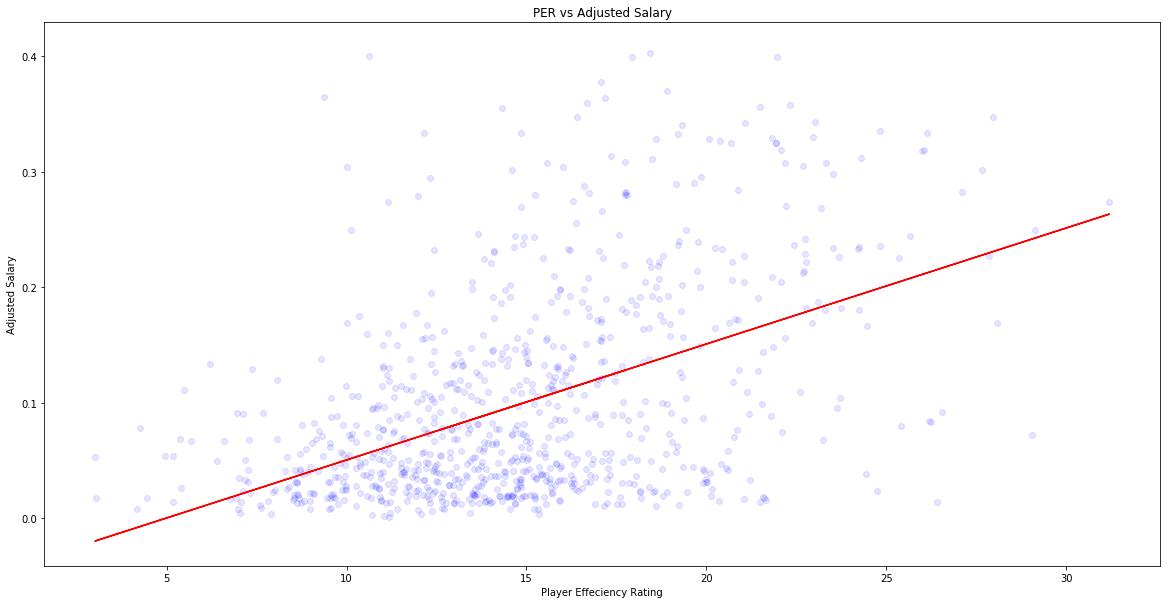

In [154]:
simple_regress(per_ewa_sal["PER"],per_ewa_sal["Adjusted Salary"])
plt.title("PER vs Adjusted Salary")
plt.xlabel("Player Effeciency Rating")
plt.ylabel("Adjusted Salary")
plt.show()

R-squared = 0.2530419776350308


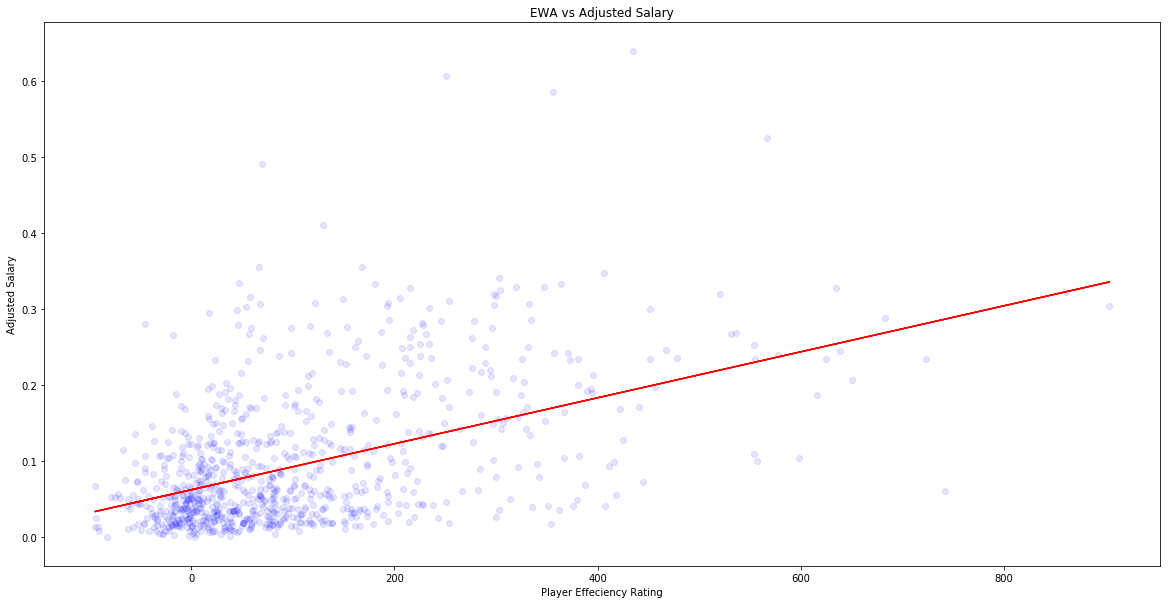

In [156]:
simple_regress(per_ewa_sal["EWA"],per_ewa_sal["Adjusted Salary"])
plt.title("EWA vs Adjusted Salary")
plt.xlabel("Player Effeciency Rating")
plt.ylabel("Adjusted Salary")
plt.show()

#### Observations
We don't see a strong correlation between either PER or EWA and Adjusted salary.  The multivariate model we made had an adjusted R-squred of .759, which is much stronger than either of these models.  Advanced analytics has become more popular in the NBA over the last 5 years, so let's see if there is a stronger correlation when just looking at the last 5 years.

### Simple Linear Regression for EWA and PER over the last 5 years

In [158]:
per_ewa_sal_last5 = per_ewa_sal[per_ewa_sal["year"] >= 2013]

R-squared = 0.2612064604520875


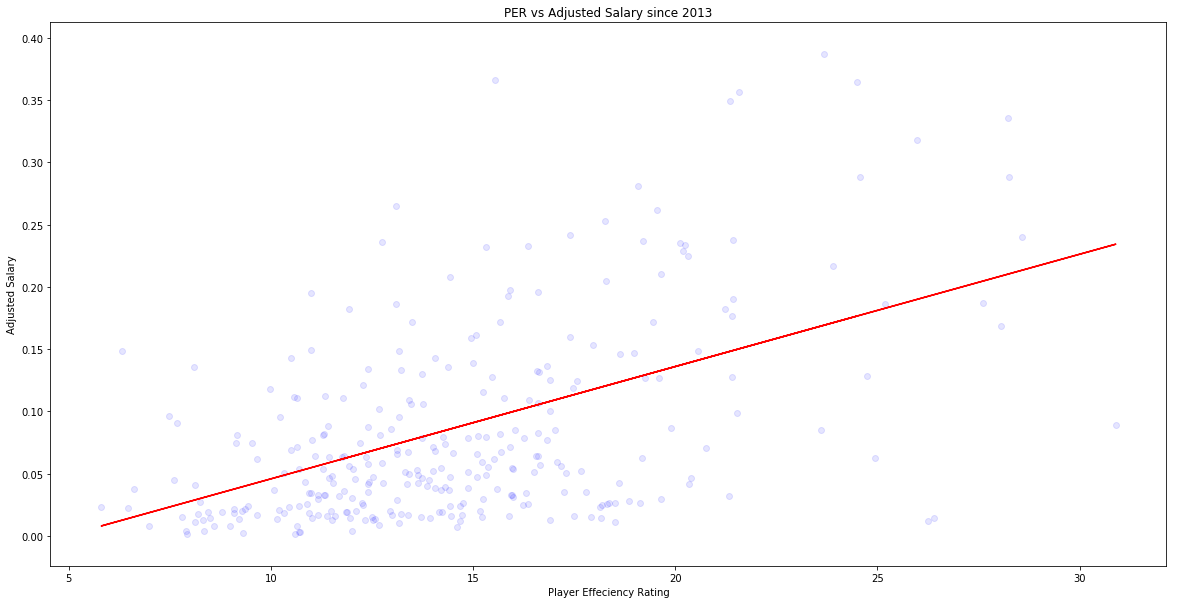

In [160]:
simple_regress(per_ewa_sal_last5["PER"],per_ewa_sal_last5["Adjusted Salary"])
plt.title("PER vs Adjusted Salary since 2013")
plt.xlabel("Player Effeciency Rating")
plt.ylabel("Adjusted Salary")
plt.show()

R-squared = 0.1142257526502547


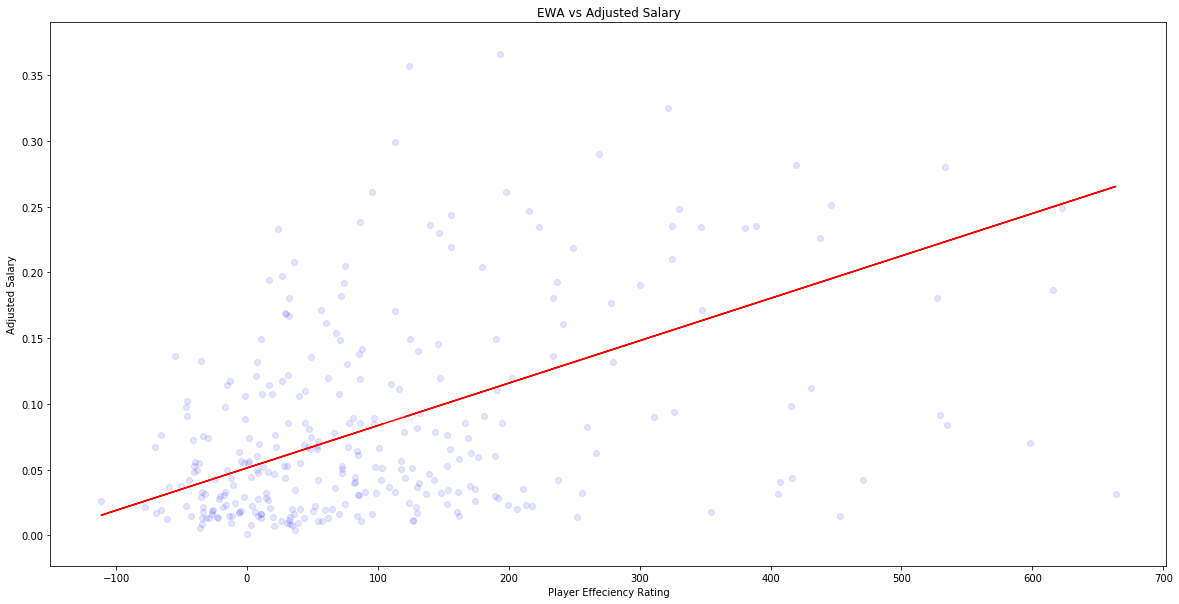

In [161]:
simple_regress(per_ewa_sal_last5["EWA"],per_ewa_sal_last5["Adjusted Salary"])
plt.title("EWA vs Adjusted Salary")
plt.xlabel("Player Effeciency Rating")
plt.ylabel("Adjusted Salary")
plt.show()

#### Observation
There is even less correlation between EWA and PER with Adjusted Salary when accounting for only the last 5 years.

### Conclusions
Since there is such poor correlation between ERA/PER and adjusted Salary, I don't deem it necessary to compare our multivariate model with the other two aggregate variables. 

---

# 3 Point Shooting Analysis
## Questions we want to answer
#### 1. The 3pt shot has seemingly become more popular in the last couple decades.  Is this true? Does this still hold true when adjusting for pace of play?
#### 2. Have any teams in particular had more increases?
#### 3. If so, has the amount of 3pt shots increased the scoring efficiency and/or scoring volume?  Does this still hold true when adjusting for pace of play?

In [18]:
import os
import pandas as pd

In [19]:
cwd = os.getcwd()
os.chdir(cwd)

### Functions that convert the text files into Pandas DataFrames

In [49]:
#Import the data set

def team_stats():
    """
    Purpose:
    Runs through the current working directory and converts each text file in a dataframe and 
    appends them to a list which is then concatenated 
    
    Returns:
    (team_stats_df) : 
    (team_stats_poss_df)
    """

    team_list = []
    team_poss_list = []
    for year in range(2000, 2018):
        team_stats_loc = "team_stats/" + str(year) + ".txt"
        team_stats_year_df = pd.read_csv(team_stats_loc, header = 0)
        team_stats_year_df.insert(loc = 0, column = 'Year', value = year) 
        team_list.append(team_stats_year_df)
        
        team_stats_poss_loc = "team_stats_per_100_possessions/" + str(year) + ".txt"
        team_stats_poss_year_df = pd.read_csv(team_stats_poss_loc, header = 0)
        team_stats_poss_year_df.insert(loc = 0, column = 'Year', value = year) 
        team_poss_list.append(team_stats_poss_year_df)

    team_stats_df = pd.concat(team_list)
    team_stats_poss_df = pd.concat(team_poss_list)
    
    new_team = []
    
    for index,row in team_stats_df.iterrows():
        clean_team = [row["Team"].replace("*","")]
        new_team += clean_team
    team_stats_df["Team"] = new_team
    
    new_team = []
    for index,row in team_stats_poss_df.iterrows():
        clean_team = [row["Team"].replace("*","")]
        new_team += clean_team
    team_stats_poss_df["Team"] = new_team
    return team_stats_df, team_stats_poss_df

In [50]:
stats_list = team_stats()
team_stats = stats_list[0]
team_poss_stats = stats_list[1]

In [22]:
#Pull just the league averages
team_averages = team_stats[team_stats["Team"] == "League Average"]
team_averages.head()

,Year,Rk,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
29,2000,NaN,League Average,82,19802,3020,6732,0.449,397,1125,0.353,2623,5607,0.468,1555,2073,0.750,1018,2501,3519,1832,651,424,1269,1911,7993
29,2001,NaN,League Average,82,19846,2926,6609,0.443,397,1124,0.354,2529,5485,0.461,1524,2039,0.748,983,2499,3482,1786,641,431,1234,1833,7774
29,2002,NaN,League Average,82,19816,2966,6664,0.445,428,1209,0.354,2538,5455,0.465,1470,1953,0.752,1003,2474,3477,1798,639,428,1186,1741,7829
29,2003,NaN,League Average,82,19842,2929,6624,0.442,421,1204,0.349,2508,5421,0.463,1518,2004,0.758,988,2481,3469,1763,651,411,1223,1784,7797
29,2004,NaN,League Average,82,19820,2871,6545,0.439,425,1224,0.347,2446,5321,0.460,1492,1985,0.752,991,2469,3461,1747,650,415,1228,1759,7659


## 3-Point Shots From Years 2000-2017

R-squared = 0.789905695201595


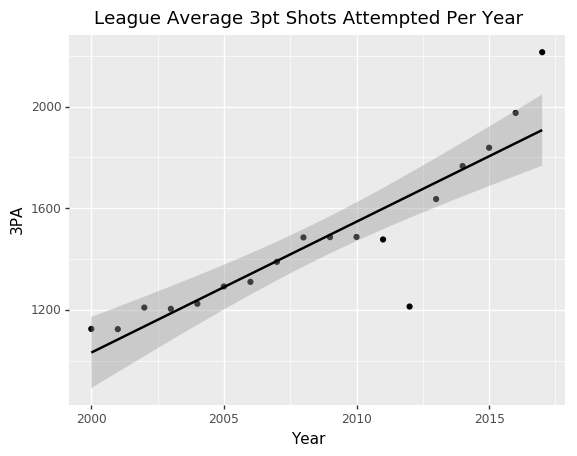

<ggplot: (-9223372029309560597)>

In [54]:
#Plot 3 Pointers attempted
import plotnine as gg

simple_regress_noplot_small(team_averages["Year"],team_averages["3PA"])

p = gg.ggplot(team_averages, gg.aes(x = "Year", y = "3PA")) + gg.geom_point() + gg.stat_smooth(method = 'lm')
p + gg.labs(title = "League Average 3pt Shots Attempted Per Year")

R-squared = 0.9138230850060536


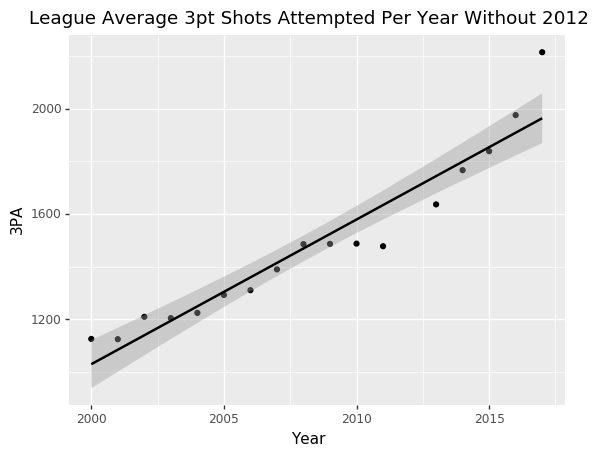

<ggplot: (-9223372029309560660)>

In [53]:
team_averages_no2012 = team_averages[team_averages["Year"] != 2012]

simple_regress_noplot_small(team_averages_no2012["Year"],team_averages_no2012["3PA"])

p = gg.ggplot(team_averages_no2012, gg.aes(x = "Year", y = "3PA")) + gg.geom_point() + gg.stat_smooth(method = 'lm')
p + gg.labs(title = "League Average 3pt Shots Attempted Per Year Without 2012")

Let's adjust for pace of play by using 3PA per 100 possessions

In [51]:
team_poss_stats_gb = team_poss_stats.groupby("Year", as_index = False).mean()
#check
team_poss_stats_gb.head(3)

,Year,Rk,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,2000,15.0,82.0,19802.413793,39.324138,87.637931,0.448828,5.172414,14.610345,0.352897,34.165517,73.017241,0.468000,20.244828,26.986207,0.750897,13.248276,32.575862,45.831034,23.862069,8.465517,5.517241,16.513793,24.886207,104.051724
1,2001,15.0,82.0,19845.517241,38.779310,87.562069,0.442862,5.258621,14.889655,0.351828,33.517241,72.675862,0.461379,20.206897,27.020690,0.748759,13.017241,33.124138,46.141379,23.668966,8.493103,5.710345,16.362069,24.289655,103.027586
2,2002,15.0,82.0,19816.206897,39.600000,88.986207,0.445069,5.703448,16.137931,0.351759,33.896552,72.858621,0.465517,19.613793,26.075862,0.752586,13.400000,33.031034,46.424138,24.000000,8.520690,5.727586,15.844828,23.248276,104.513793


R-squared = 0.9185085695831565


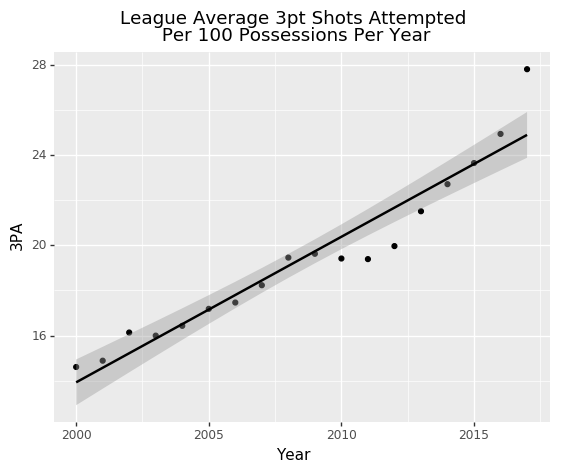

<ggplot: (-9223372029315181063)>

In [52]:
#Plot 3 Pointers attempted per 100 possessions
import plotnine as gg

simple_regress_noplot_small(team_poss_stats_gb["Year"],team_poss_stats_gb["3PA"])

p = gg.ggplot(team_poss_stats_gb, gg.aes(x = "Year", y = "3PA")) + gg.geom_point() + gg.stat_smooth(method = 'lm')
p + gg.labs(title = "League Average 3pt Shots Attempted\n Per 100 Possessions Per Year")

### The 3pt shot has seemingly become more popular in the last couple decades. Is this true? Does this still hold true when adjusting for pace of play?
Yes, from 2000 to 2017, the amount of 3 point shots attempted has increased substantially. With are R-squared value of .789, there is a strong correlation between Year and 3 point shots attempted, especially if the outlier year of 2012 is removed, which causes the R-squared value to increase to .913.
#### Does this still hold true when adjusting for pace of play?
Yes, even more so. After adjusting for pace of play, the R-squared for Years vs 3-Point Shots attempted per 100 possessions was .918, which suggests a very strong correlation.

---

## 3-Point Attempts by Team

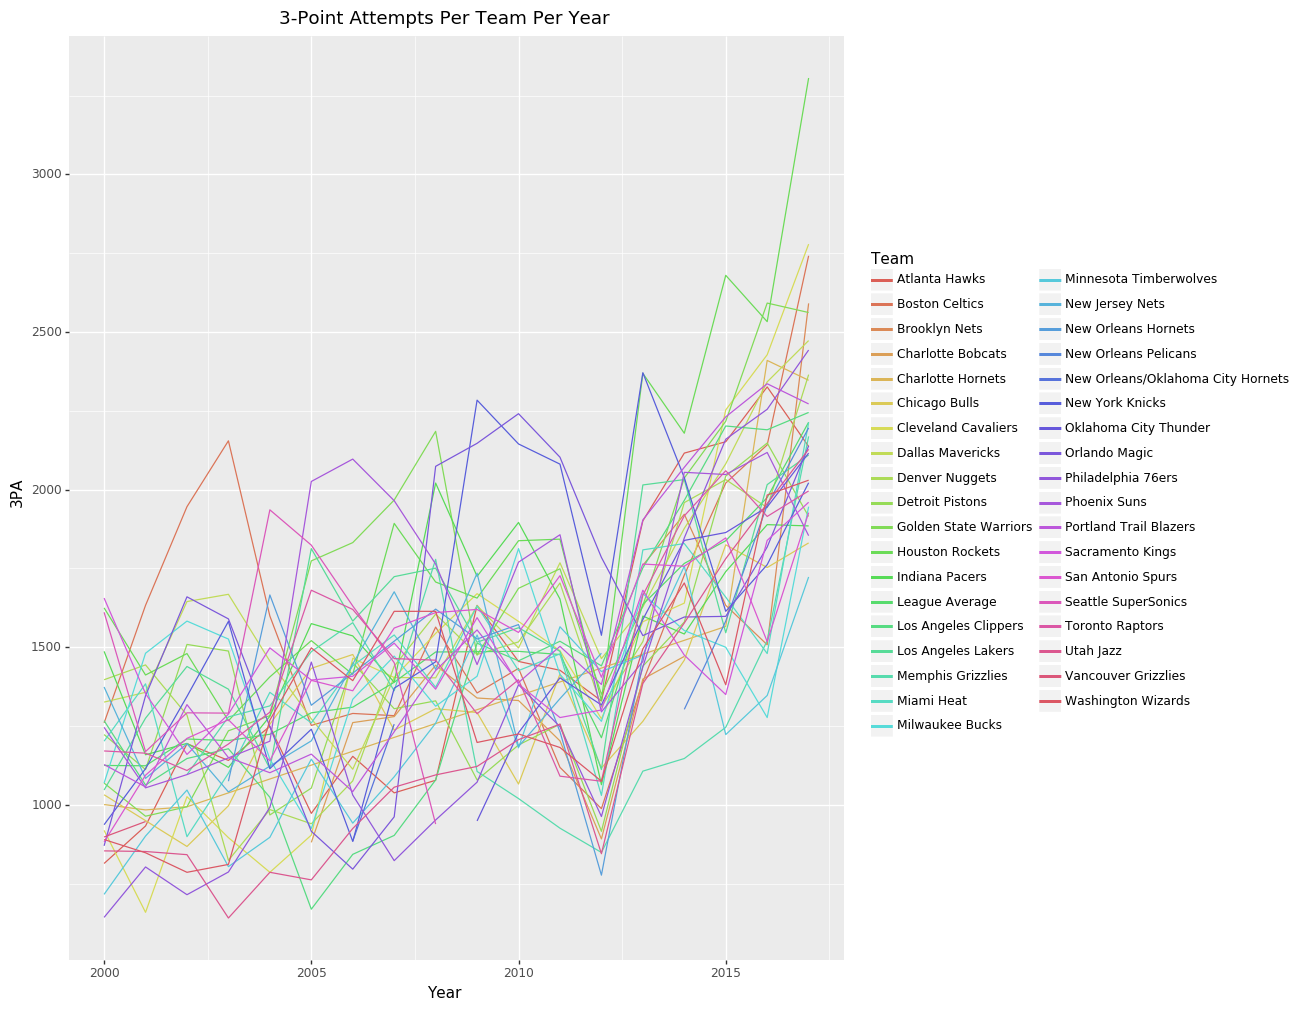

<ggplot: (-9223372029311337493)>

In [40]:
p = gg.ggplot(team_stats, gg.aes(x="Year",y= "3PA", color = "Team")) + gg.geom_line()
p + gg.theme(figure_size = (10,12)) + gg.labs(title = "3-Point Attempts Per Team Per Year")

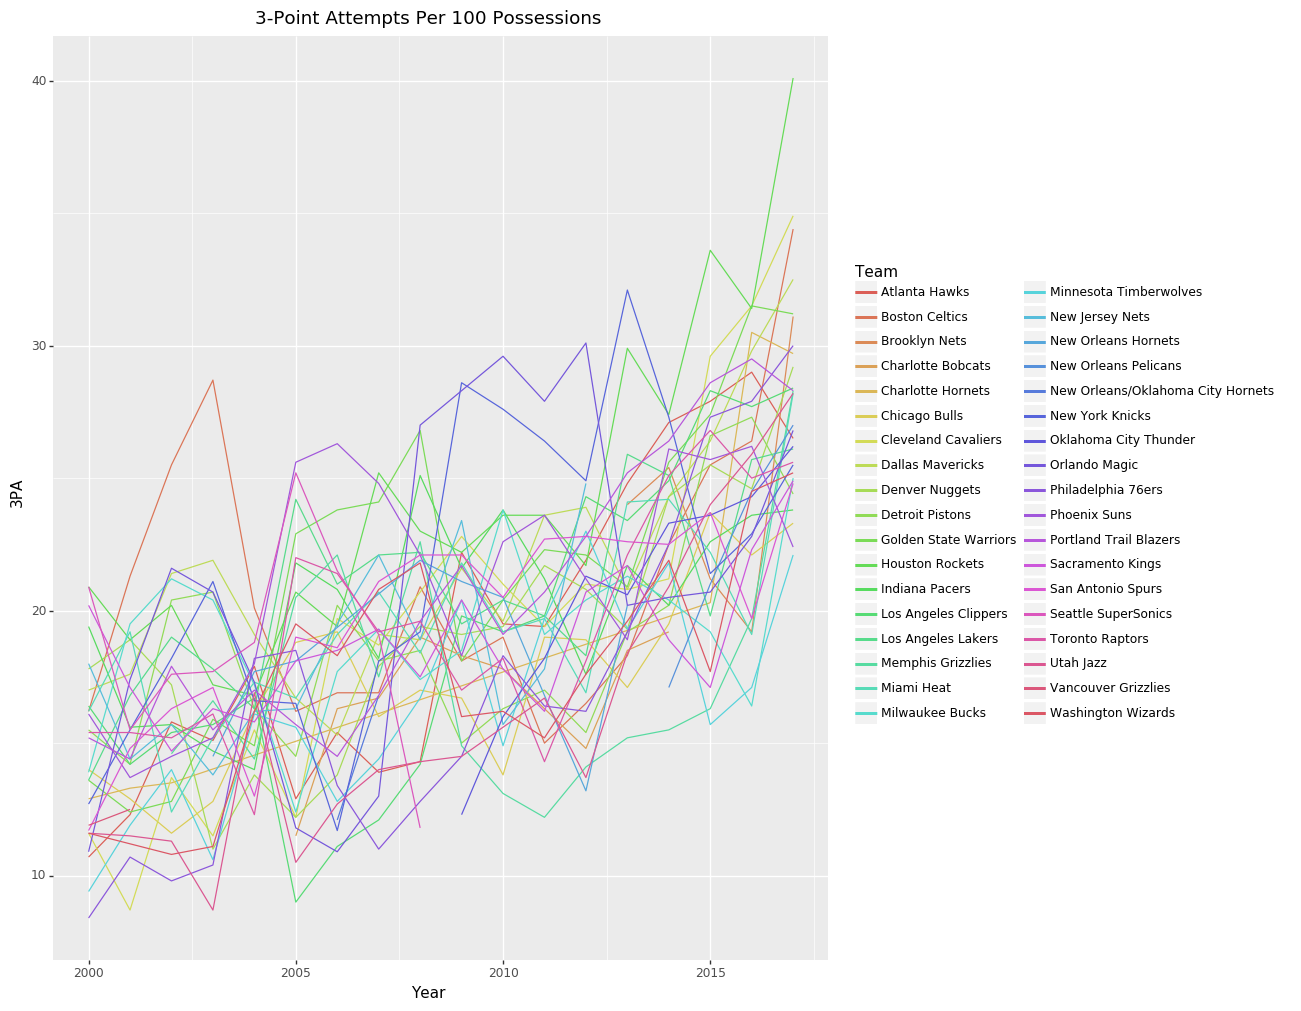

<ggplot: (7545764721)>

In [56]:
p = gg.ggplot(team_poss_stats, gg.aes(x="Year",y= "3PA", color = "Team")) + gg.geom_line()
p + gg.theme(figure_size = (10,12)) + gg.labs(title = "3-Point Attempts Per 100 Possessions")

In [67]:
team_poss_stats[team_poss_stats["Year"] == 2003].sort_values("3PA",ascending=False).head(1)

,Year,Rk,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
21,2003,22,Boston Celtics,82,19830,36.0,86.7,0.415,9.6,28.7,0.334,26.4,58.0,0.455,19.7,26.6,0.742,11.3,32.9,44.2,21.0,9.6,4.0,15.3,23.4,101.2


In [69]:
team_poss_stats[team_poss_stats["Year"] == 2017].sort_values("3PA",ascending=False).head(5)

,Year,Rk,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
1,2017,2,Houston Rockets,82,19780,40.1,86.8,0.462,14.3,40.1,0.357,25.8,46.7,0.552,20.2,26.4,0.766,10.8,33.3,44.1,25.1,8.1,4.3,15.0,19.8,114.7
3,2017,4,Cleveland Cavaliers,82,19880,41.1,87.4,0.470,13.4,34.9,0.384,27.7,52.5,0.528,18.0,24.0,0.748,9.6,35.4,45.0,23.3,6.8,4.1,14.1,18.7,113.6
6,2017,7,Boston Celtics,82,19755,39.8,87.6,0.454,12.4,34.4,0.359,27.4,53.2,0.515,19.3,23.9,0.807,9.3,33.9,43.2,26.0,7.7,4.3,13.7,21.2,111.2
29,2017,30,Dallas Mavericks,82,19780,39.0,88.8,0.440,11.6,32.5,0.355,27.5,56.3,0.489,16.0,19.9,0.801,8.5,33.1,41.6,22.4,8.1,4.0,12.8,20.6,105.6
0,2017,1,Golden State Warriors,82,19780,43.0,86.8,0.495,11.9,31.2,0.383,31.0,55.7,0.557,17.7,22.5,0.788,9.4,34.9,44.3,30.3,9.5,6.7,14.7,19.3,115.6


### Have any teams in particular had more increases in 3 point attempts?
Yes, what we see is in the early 2000's the Boston Celtics shot significantly more 3-point shots than any other team at 28.7 3PA per game, but they quickly fell back towards the median by 2004.  More interestingly, in the 2017 season, we can see that the Houston Rockets are shooting a whopping 40.1 attempts per game. The Cleveland Cavaliers, Boston Celtics, and Golden State Warriors, are also close behind, each shooting over 31 attempts per game.  All four of these teams are seen as contenders, which leads me to believes that 3-Point Attempts may be assoiaciated with win percentage as well as scoring volume and efficiency, let's look at that.

---

## 3-point Shooting's Relation to Efficiency and Scoring volume

#### 3pt attempts vs Field Goal Efficiency w/ simple linear regression

R-squared = 0.2359773296013956


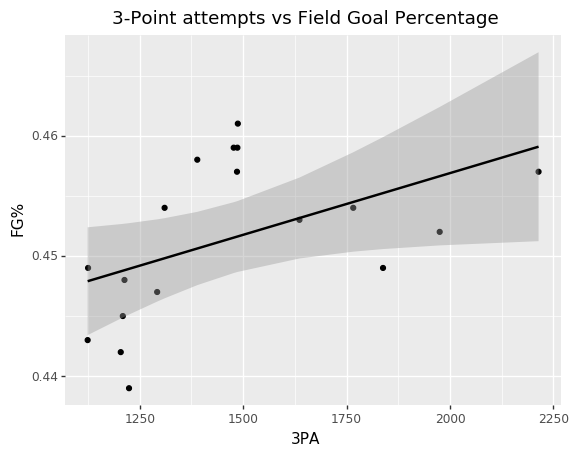

<ggplot: (-9223372029315535868)>

In [86]:
simple_regress_noplot_small(team_averages["3PA"],team_averages["FG%"])

p = gg.ggplot(team_averages, gg.aes(y = "FG%", x = "3PA")) + gg.geom_point() + gg.stat_smooth(method = 'lm')
p + gg.labs(title = "3-Point attempts vs Field Goal Percentage")

R-squared = 0.23029879928607322


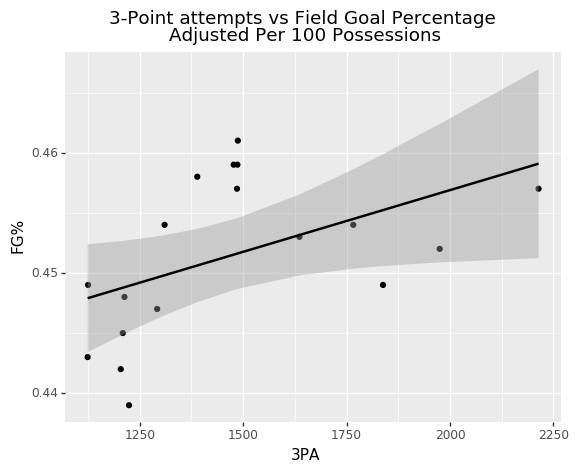

<ggplot: (-9223372029309135216)>

In [89]:
simple_regress_noplot_small(team_poss_stats_gb["3PA"],team_poss_stats_gb["FG%"])

p = gg.ggplot(team_averages, gg.aes(y = "FG%", x = "3PA")) + gg.geom_point() + gg.stat_smooth(method = 'lm')
p + gg.labs(title = "3-Point attempts vs Field Goal Percentage \nAdjusted Per 100 Possessions")

#### Observations:
This positive correlation is counter-intuitive. Although we see a weak correlation, it's still positive, but we would expect the overall field goal effeciency to go down as the frequency of 3-point attempts increase.  We also see little difference in the R-score when adjusted for pace of play which can only logically leave two conclusions, possible both.

1. Higher frequencies of 3-point attempts are correlated with higher 2-pt Field Goal percentages.
2. Higher frequencies of 3-point attempts are correlated with higher 3-pt Field Goal percentages.

R-squared = 0.7167924623189978


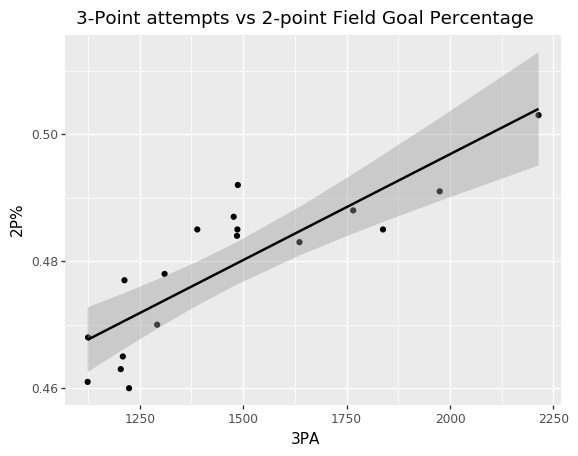

<ggplot: (-9223372029315168070)>

In [93]:
simple_regress_noplot_small(team_averages["2P%"],team_averages["3PA"])

p = gg.ggplot(team_averages, gg.aes(y = "2P%", x = "3PA")) + gg.geom_point() + gg.stat_smooth(method = 'lm')
p + gg.labs(title = "3-Point attempts vs 2-Point Field Goal Percentage")

R-squared = 0.08766730870931204


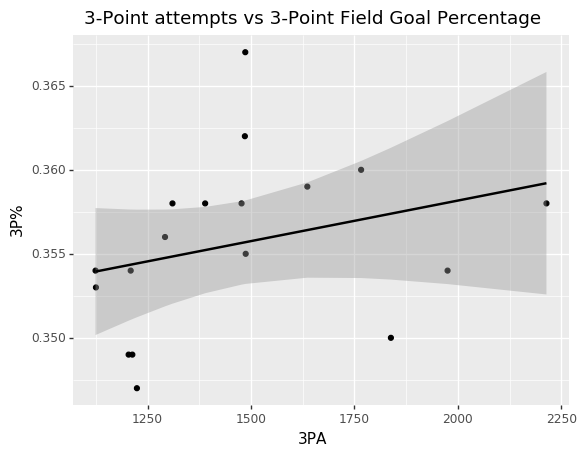

<ggplot: (-9223372029315192965)>

In [95]:
simple_regress_noplot_small(team_averages["3P%"],team_averages["3PA"])

p = gg.ggplot(team_averages, gg.aes(y = "3P%", x = "3PA")) + gg.geom_point() + gg.stat_smooth(method = 'lm')
p + gg.labs(title = "3-Point attempts vs 3-Point Field Goal Percentage")

#### Conclusion
There is little correlation between increases 3-Point Attempts and increases 3-Point Percentage, so we conclude that the reason we see and increase in overall FG% when there is an increase in 2-point field goal efficiency, which we see in the above plot.  The R-squared between 3-Point attempts and 2-Point Fg% is .716 which is fairly strong.

### 3-Point Shooting and Scoring Volume

R-squared = 0.3921811438689855


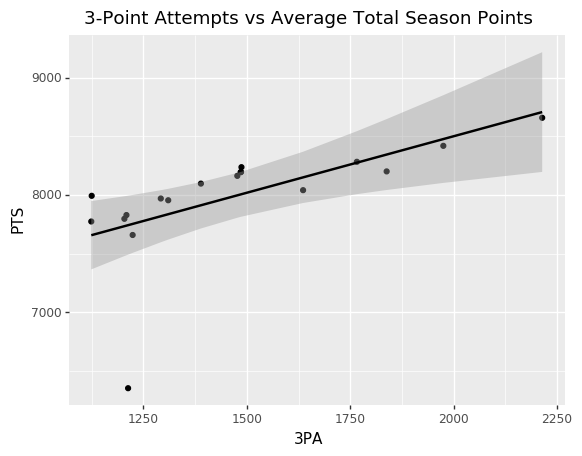

<ggplot: (7542887239)>

In [103]:
simple_regress_noplot_small(team_averages["PTS"],team_averages["3PA"])

p = gg.ggplot(team_averages, gg.aes(y = "PTS", x = "3PA")) + gg.geom_point() + gg.stat_smooth(method = 'lm')
p + gg.labs(title = "3-Point Attempts vs Average Total Season Points")

#### Observation
There seems to be a strong correlation, but the 2012 Season lockout is what I'm guessing is causing the outlier, becuase that season had less games

R-squared = 0.7988351748595724


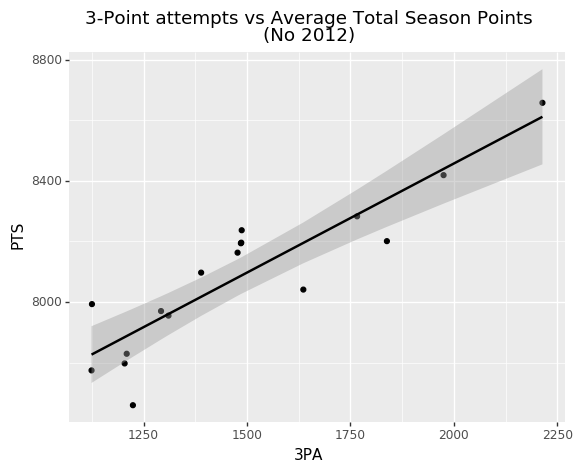

<ggplot: (-9223372029313512402)>

In [104]:
team_averages_no2012 = team_averages[team_averages["Year"] != 2012]

simple_regress_noplot_small(team_averages_no2012["PTS"],team_averages_no2012["3PA"])

p = gg.ggplot(team_averages_no2011, gg.aes(y = "PTS", x = "3PA")) + gg.geom_point() + gg.stat_smooth(method = 'lm')
p + gg.labs(title = "3-Point attempts vs Average Total Season Points\n(No 2012)")

#### Observation
Removing the 2012 season increased the R-squared from .39 to .79, which shows a strog corellation between 3PA and points scored. Let's see if this hold's true when adjusting for pace of play

R-squared = 0.42618239837417704


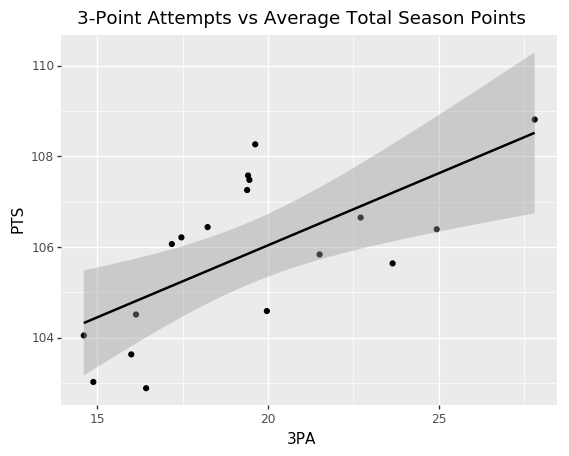

<ggplot: (-9223372029311319692)>

In [105]:
simple_regress_noplot_small(team_poss_stats_gb["PTS"],team_poss_stats_gb["3PA"])

p = gg.ggplot(team_poss_stats_gb, gg.aes(y = "PTS", x = "3PA")) + gg.geom_point() + gg.stat_smooth(method = 'lm')
p + gg.labs(title = "3-Point Attempts vs Average Total Season Points")

#### Observation
Interestingly, after adjusting for pace of play, we don't see nearly as strong of correlation between 3PA and points scored, which suggest their is a relationship between 3PA and pace of play.

### Has the amount of 3pt shots increased the scoring efficiency and/or scoring volume? Does this still hold true when adjusting for pace of play?

We conclude that the amount of 3 point shot attempts does correlate with an increase in scoring efficiency, mainly through and increase in 2-point field goal efficiency, not through more efficient 3-point shooting.  This still holds true when adjusting for pace of play because adjusting on a per possession basis has no impact on percentages, and the effect from the 3PA adjustments were minimal.

There is a strong relationship between scoring volume and the increase in 3pt shots, but when adjusting for a changes in the pace of play, the relationship becomes weaker.  There is still a moderately positive correlation between 3PA and scoring volume after the adjustment though.